# Install Libs

# Import Metadata

In [2]:
# ----------------------------
# Prepare training data from Metadata file
# ----------------------------
from IPython.display import Audio
import math, random
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score
#from sklearn.preprocessing import LabelEncoder
#from sklearn.model_selection import train_test_split
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from torchaudio import transforms

sys.path.insert(1, os.getcwd() + '/lib')

# Read metadata file
os.chdir('../')
df = pd.read_csv('data/metadata.csv')
df.head()
#os.chdir('notebooks/')

# Construct file path by concatenating fold and file name
df['relative_path'] = df['path'].copy()
df['classID'] = df['label'].copy()
df_t = df[df['subset'] == 'train'].copy()
df_v = df[df['subset'] == 'validation'].copy()

# Take relevant columns
df_t = df_t.reset_index()[['relative_path', 'classID']].copy()
df_v = df_v.reset_index()[['relative_path', 'classID']].copy()
df_v.head()

,relative_path,classID
0,data/val/Atrapsaltacorticina_GBIF2901504947_IN...,3
1,data/val/Chorthippusbrunneus_XC751398-dat022-0...,10
2,data/val/Psaltodaplaga_GBIF3031797565_IN684694...,53
3,data/val/Omocestusviridulus_XC752267-dat013-00...,39
4,data/val/Omocestusviridulus_XC752263-dat012-00...,39


# Transform Audio Files

In [3]:
class AudioUtil():
    
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)

    # ----------------------------
    # Convert the given audio to the desired number of channels
    # ----------------------------
    @staticmethod
    def rechannel(aud, new_channel):

        sig, sr = aud

        if (sig.shape[0] == new_channel):
            # Nothing to do
            return aud

        if (new_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = torch.cat([sig, sig])

        return ((resig, sr))

    # ----------------------------
    # Since Resample applies to a single channel, we resample one channel at a time
    # ----------------------------
    @staticmethod
    def resample(aud, newsr):

        sig, sr = aud

        if (sr == newsr):
            # Nothing to do
            return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])

        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))

    # ----------------------------
    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    # ----------------------------
    @staticmethod
    def pad_trunc(aud, max_ms):

        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
          # Truncate the signal to the given length
          sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)

    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):

        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)

        return (spec)

    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):

        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
    @staticmethod
    def time_shift(aud, shift_limit):

        sig,sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)

        return (sig.roll(shift_amt), sr)

# Audio DataLoaders

In [4]:
# Define the desired audio features
sample_rate = 44100  # Desired sample rate for audio files
channels = 2         # Channels of audio files
batch_size = 16      # Size of batches
sample_time = 16000  # Time length of sample audio files
shifting = 0.4       # Shifting of sample audio files
n_mfcc = 100         # Number of Mel-frequency cepstral coefficients (MFCCs)
n_fft = 2048         # Length of the FFT window
hop_length = 512     # Hop length for the STFT
n_mels = 128         # Number of Mel bands for the Mel-spectrogram
max_length = 128     # Maximum length of the spectrogram
mask_pct = 0.1       # Mask size
freq_masks = 2       # Frequency of masks
time_masks = 2       # Time of masks

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    
    def __init__(self, df):
        self.df = df
        self.duration = sample_time
        self.sr = sample_rate
        self.channel = channels
        self.shift_pct = shifting

    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        return len(self.df)    

    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        # Absolute file path of the audio file - concatenate the audio directory with
        # the relative path
        audio_file = self.df.loc[idx, 'relative_path']
        # Get the Class ID
        class_id = self.df.loc[idx, 'classID']

        aud = AudioUtil.open(audio_file)
        # Some sounds have a higher sample rate, or fewer channels compared to the
        # majority. So make all sounds have the same number of channels and same 
        # sample rate. Unless the sample rate is the same, the pad_trunc will still
        # result in arrays of different lengths, even though the sound duration is
        # the same.
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)

        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=n_mels, n_fft=n_fft, hop_len=hop_length)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=mask_pct, n_freq_masks=freq_masks, n_time_masks=time_masks)

        return aug_sgram, class_id

# Prepare Batches

In [5]:
# Use train/val split in project
train_ds = SoundDS(df_t)
val_ds = SoundDS(df_v)

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# Create Model

In [6]:
# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=66)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Training

In [7]:
# ----------------------------
# Inference Loop
# ----------------------------
def inference(model, val_dl):
    
    correct_prediction = 0
    total_prediction = 0
    predicted_labels = []
    true_labels = []
    
    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)

            # Collect predicted and true labels for calculating F1-score
            predicted_labels.extend(prediction.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
    
    acc = correct_prediction*100/total_prediction
    f1 = f1_score(true_labels, predicted_labels, average='macro')*100
    print(f'----- Validation ----- Accuracy: {acc:.2f}%, F1-Score: {f1:.2f}%, Total items: {total_prediction}')
    
    return f1

# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, val_dl, num_epochs, MODEL_PATH = os.getcwd() + '/models/CNN-ADLSC/output/model.tar.gz'):
    
    # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                    steps_per_epoch=int(len(train_dl)),
                                                    epochs=num_epochs,
                                                    anneal_strategy='linear')
    
    # Repeat for each epoch
    for epoch in range(num_epochs):
        
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        predicted_labels = []
        true_labels = []
        f1_list = [60]
        
        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)
            
            #print("### labels.max()", labels.max())
            #print("### labels.min()", labels.min())

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            #print(inputs_m, inputs_s)
            inputs = (inputs - inputs_m) / inputs_s
            
            #print(labels.shape)
            #print(inputs.shape)
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            
            # Collect predicted and true labels for calculating F1-score
            predicted_labels.extend(prediction.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            if i % 50 == 0:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction*100/total_prediction
        
        f1 = f1_score(true_labels, predicted_labels, average='macro')*100
        
        print(f'-----    Test    ----- Epoch: {epoch+1}, Loss: {avg_loss:.2f}')
        print(f'-----    Test    ----- Accuracy: {acc:.2f}%, F1-Score: {f1:.2f}%, Total items: {total_prediction}')
        
        # Run inference on trained model with the validation set
        f1_inference = inference(model, val_dl)
        
        if f1_inference > np.array(f1_list).max():
            print(f"Saving final model...")
            torch.save({
                        'epoch': num_epochs,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': criterion,
                        }, MODEL_PATH)
            print(MODEL_PATH)
        
        f1_list.append(f1_inference)

    print('Finished Training')

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
num_epochs = 500
MODEL_PATH = os.getcwd() + '/models/CNN-ADLSC/output/model.tar.gz'

# Create the model and put it on the GPU if available
myModel = AudioClassifier()

# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
myModel = myModel.to(device)

# Check that it is on Cuda
next(myModel.parameters()).device

training(myModel, train_dl, val_dl, num_epochs, MODEL_PATH)

[1,     1] loss: 0.415
[1,    51] loss: 21.587
[1,   101] loss: 42.515
-----    Test    ----- Epoch: 1, Loss: 4.21
-----    Test    ----- Accuracy: 2.17%, F1-Score: 0.79%, Total items: 1752
----- Validation ----- Accuracy: 3.11%, F1-Score: 1.66%, Total items: 579
[2,     1] loss: 0.414
[2,    51] loss: 21.145
[2,   101] loss: 41.740
-----    Test    ----- Epoch: 2, Loss: 4.13
-----    Test    ----- Accuracy: 4.00%, F1-Score: 1.64%, Total items: 1752
----- Validation ----- Accuracy: 4.84%, F1-Score: 1.24%, Total items: 579
[3,     1] loss: 0.403
[3,    51] loss: 20.893
[3,   101] loss: 41.241
-----    Test    ----- Epoch: 3, Loss: 4.08
-----    Test    ----- Accuracy: 4.97%, F1-Score: 1.78%, Total items: 1752
----- Validation ----- Accuracy: 5.01%, F1-Score: 1.71%, Total items: 579
[4,     1] loss: 0.402
[4,    51] loss: 20.654
[4,   101] loss: 40.850
-----    Test    ----- Epoch: 4, Loss: 4.04
-----    Test    ----- Accuracy: 5.19%, F1-Score: 1.98%, Total items: 1752
----- Validation -

# Load Model

In [7]:
def inference(model, val_dl):
    
    correct_prediction = 0
    total_prediction = 0
    predicted_labels = []
    true_labels = []
    
    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)

            # Collect predicted and true labels for calculating F1-score
            predicted_labels.extend(prediction.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
    
    acc = correct_prediction*100/total_prediction
    f1 = f1_score(true_labels, predicted_labels, average='macro')*100
    print(f'Accuracy: {acc:.2f}%, F1-Score: {f1:.2f}%, Total items: {total_prediction}')

In [10]:
MODEL_PATH = os.getcwd() + '/models/CNN-ADLSC/output/model.tar.gz'

myModel = AudioClassifier()
myModel.load_state_dict(torch.load(MODEL_PATH))
myModel.eval()

# Set random seed for reproducibility
torch.manual_seed(42)

# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
myModel = myModel.to(device)

# Check that it is on Cuda
next(myModel.parameters()).device

# Run inference on trained model with the validation set
inference(myModel, val_dl)

Accuracy: 67.88%, F1-Score: 59.96%, Total items: 579


In [17]:
# Run inference on trained model with the validation set
#MODEL_PATH = os.getcwd() + '/models/CNN-ADLSC/output/model_56f1.tar.gz'
inference(myModel, val_dl)

Accuracy: 65.28%, F1-Score: 56.52%, Total items: 579


# Vis

In [ ]:
import librosa
import matplotlib
import matplotlib.pyplot as plt

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
def show_spectro(spec, label='', ax=None, figsize=(6,6)):
    if (not ax):
        _,ax = plt.subplots(1, 1, figsize=figsize)
    # Reduce first dimension if it is greyscale
    ax.imshow(spec if (spec.shape[0]==3) else spec.squeeze(0))
    ax.set_title(f'{label}, {list(spec.shape)}')

show_spectro(train_ds[0][0][0])

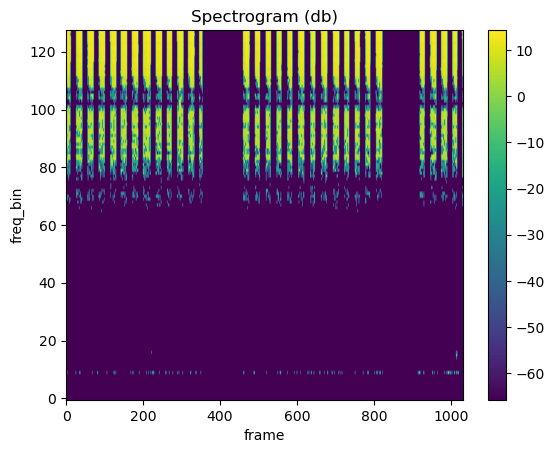

In [31]:
plot_spectrogram(train_ds[0][0][0])

In [36]:
train_ds[0][0].shape

torch.Size([2, 128, 1032])

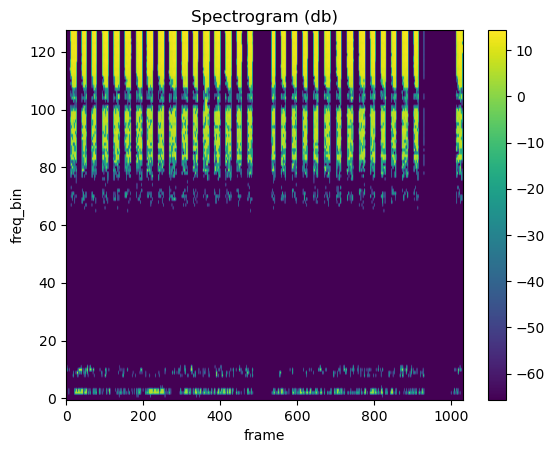

In [30]:
plot_spectrogram(train_ds[0][0][1])

In [ ]:
from nb_util import save_pickle, load_pickle, DebugRand
from nb_audio import AudioUtil
from nb_data import AudioClassificationDataBundle
from nb_arch import ArchBase, CNNArch, GeneralRelu, BatchNorm, InitConv
from nb_app import AppBase
